In [1]:
# try:
#   from utils import install_packages
# except:
#   # Colab
#   !git clone https://github.com/mackelab/simformer.git
#   from simformer.example.utils import install_packages
#   from google.colab import output
#   output.enable_custom_widget_manager()

In [2]:
# This can run for 4 min if nothing is installed/has to be down/upgraded
# install_packages() # install required packages if necessary, might requires restarting the kernel/colab runtime

In [3]:
# load autoreload extension
%load_ext autoreload
%autoreload 2
%cd '/lhome/ific/a/aamerio/github/diffusion'
%pwd

/lhome/ific/a/aamerio/github/diffusion


'/lhome/ific/a/aamerio/github/diffusion'

In [4]:
import sys
sys.path.append('./src')
sys.path.append('./reference/simformer-main/src/probjax')
sys.path.append('./reference/simformer-main/src/scoresbibm')

In [5]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.random import PRNGKey
from jax import Array
import os
jax.devices() # Should be cuda
_ = os.system("nvidia-smi  --query-gpu=name --format=csv,noheader") # Should show GPU info

Tesla V100-PCIE-32GB


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd

from functools import partial
from typing import Tuple, List, Optional

import haiku as hk # Neural network library
import optax # Gradient-based optimization in JAX

# Some small helper functions
from probjax.nn.transformers import Transformer
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.loss_fn import denoising_score_matching_loss
from probjax.distributions.sde import VESDE
from probjax.distributions import Empirical, Independent

# from scoresbibm.utils.plot import use_style

from sbi.analysis import pairplot
import numpy as np

In [7]:
# Set random key
key = jax.random.PRNGKey(0)

### 1) Setting up a toy problem

This is a simple toy problem to test the functionality of the `Simformer` method.
$$ \theta \sim \mathcal{N}(\theta; 0, 3^2) \qquad \qquad  x_1 \sim \mathcal{N}(x_1; 2\cdot\sin(\theta), 0.5^2)  \qquad \qquad   x_2 \sim \mathcal{N}(x_2;0.1\cdot \theta^2,  (0.5\cdot |x_1|)^2)$$

Here we have 3 nonlinear related Gaussian variables. The associated joint distirbution is visualized below.

In [8]:
def generate_data(key: PRNGKey, n:int):
    key1, key2, key3 = jrandom.split(key,3)
    theta1 = jrandom.normal(key1, (n, 1))  * 3 # Some prior on a parameter
    x1 = 2*jnp.sin(theta1) + jrandom.normal(key2, (n, 1)) * 0.5 # Some data generated from the parameter 
    x2 = 0.1*theta1**2 + 0.5*jnp.abs(x1)*jrandom.normal(key3, (n, 1)) # Some data generated from the parameter
    return jnp.concatenate([theta1,x1, x2], axis=1).reshape(n, -1, 1)

def log_potential(theta1: Array, x1: Array, x2: Array, sigma_x1:float=0.5, sigma_x2:float=0.5, mean_loc:float=0.0, mean_scale:float=3.0 ):
    log_prob_theta = jax.scipy.stats.norm.logpdf(theta1, mean_loc, mean_scale)
    if x1 is not None:
        log_prob_x1 = jax.scipy.stats.norm.logpdf(x1, 2*jnp.sin(theta1), sigma_x1)
    else:
        log_prob_x1 = 0
    if x2 is not None:
        log_prob_x2 = jax.scipy.stats.norm.logpdf(x2, 0.1*theta1**2,  sigma_x2*jnp.abs(x1))
    else:
        log_prob_x2 = 0
    
    return log_prob_theta + log_prob_x1 + log_prob_x2
    

data = generate_data(jrandom.PRNGKey(1), 10000)  # Shape: (n, nodes, dim) here dim = 1
nodes_max = data.shape[1]
node_ids = jnp.arange(nodes_max)

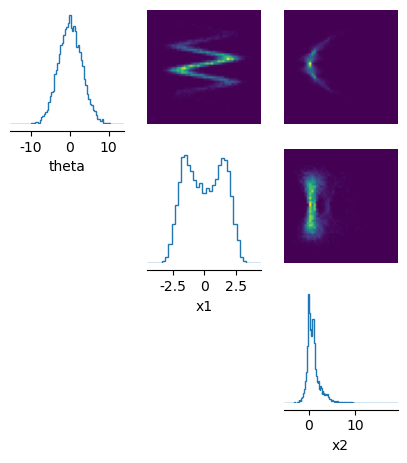

In [9]:
_ = pairplot(np.array(data[...,0]), labels=["theta", "x1", "x2"], figsize=(5,5))

### 2) Setting up the diffusion process

We will use the VESDE i.e. the variance exploding stochastic differential equation. 

In [10]:

# VESDE 
T = 1.
T_min = 1e-2
sigma_min = 1e-3
sigma_max = 15.

p0 = Independent(Empirical(data), 1) # Empirical distribution of the data
sde = VESDE(p0, sigma_min=sigma_min , sigma_max=sigma_max)

# Scaling fn for the output of the score model
def output_scale_fn(t, x):
    scale = jnp.clip(sde.marginal_stddev(t, jnp.ones_like(x)), 1e-2, None)
    return (1/scale * x).reshape(x.shape)

### 3) Building the Simformer

This can be divided into two parts, each offering various choices:

* **Tokenizer**: 
This component jointly embeds 'x', 'node_ids', and the 'condition_mask' into a unified 
vector known as a token.
    * **Value Embedding**: Embeds the value of the variable.
    * **Node Embedding**: Embeds the node ID.
    * **Condition Embedding**: Embeds the condition mask.
* **Transformer**: This is a transformer model that takes tokens as input and generates scores for each node.
    * **Num_heads**: Specifies the number of heads in the multi-head attention mechanism.
    * **Attn_size**: Determines the size of attention, i.e., the dimensions to which query and key are projected.
    * **Num_layers**: Sets the number of layers in the transformer.
    * **Widening_factor**: Specifies the factor by which the hidden size of the MLP is increased in each layer.

In this example, we construct a compact Simformer with 2 layers and 2 heads.


In [11]:
dim_value = 20      # Size of the value embedding
dim_id = 20         # Size of the node id embedding
dim_condition = 10  # Size of the condition embedding


def model(t: Array, x: Array, node_ids: Array, condition_mask:Array, edge_mask: Optional[Array]=None):
    """Simplified Simformer model.

    Args:
        t (Array): Diffusion time
        x (Array): Value of the nodes
        node_ids (Array): Id of the nodes
        condition_mask (Array): Condition state of the nodes
        edge_mask (Array, optional): Edge mask. Defaults to None.

    Returns:
        Array: Score estimate of p(x_t)
    """
    batch_size, seq_len, _ = x.shape
    condition_mask = condition_mask.astype(jnp.bool_).reshape(-1,seq_len, 1)
    node_ids = node_ids.reshape(-1,seq_len)
    t = t.reshape(-1,1, 1)
    
    # Diffusion time embedding net (here we use a Gaussian Fourier embedding)
    embedding_time = GaussianFourierEmbedding(64)  # Time embedding method
    time_embeddings = embedding_time(t)
    
    # Tokinization part --------------------------------------------------------------------------------

    embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)    # Value embedding net (here we just repeat the value)
    embedding_net_id = hk.Embed(nodes_max, dim_id, w_init=hk.initializers.RandomNormal(stddev=3.))   # Node id embedding nets (here we use a learnable random embedding vector)
    condition_embedding = hk.get_parameter("condition_embedding", shape=(1,1,dim_condition), init=hk.initializers.RandomNormal(stddev=0.5)) # Condition embedding (here we use a learnable random embedding vector)
    condition_embedding = condition_embedding * condition_mask # If condition_mask is 0, then the embedding is 0, otherwise it is the condition_embedding vector
    condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))
    
    # Embed inputs and broadcast
    value_embeddings = embedding_net_value(x)
    id_embeddings = embedding_net_id(node_ids)
    value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)
    
    # Concatenate embeddings (alternatively you can also add instead of concatenating)
    x_encoded = jnp.concatenate([value_embeddings, id_embeddings, condition_embedding], axis=-1)
    
    # Transformer part --------------------------------------------------------------------------------
    model = Transformer(num_heads=2, num_layers=2, attn_size=10, widening_factor=3) 
    
    # Encode - here we just use a transformer to transform the tokenized inputs into a latent representation
    h = model(x_encoded, context=time_embeddings, mask=edge_mask)

    # Decode - here we just use a linear layer to get the score estimate (we scale the output by the marginal std dev)
    out = hk.Linear(1)(h)
    out = output_scale_fn(t, out) # SDE dependent output scaling
    return out


In [12]:
# In Haiku, we need to initialize the model first, before we can use it.
init, model_fn = hk.without_apply_rng(hk.transform(model)) # Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument, hence is a "pure function")
params = init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))

In [13]:
# Here we can see the total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

Total number of parameters:  45774


/tmp/ipykernel_130056/1091878057.py:2: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))


{'embed': {'embeddings': (3, 20)},
 'gaussian_fourier_embedding': {'B': (33, 1)},
 'linear': {'b': (1,), 'w': (50, 1)},
 'transformer/layer_norm': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_1': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_2': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_3': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_4': {'offset': (50,), 'scale': (50,)},
 'transformer/linear': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_1': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_2': {'b': (50,), 'w': (64, 50)},
 'transformer/linear_3': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_4': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_5': {'b': (50,), 'w': (64, 50)},
 'transformer/multi_head_attention/key': {'b': (20,), 'w': (50, 20)},
 'transformer/multi_head_attention/linear': {'b': (50,), 'w': (20, 50)},
 'transformer/multi_head_attention/query': {'b': (20,), 'w': (50, 20)},
 'transformer/multi

### 4) The loss
Here we will show the variant which targets to learn:

* Correct joint $p(\theta,x_1, x_2)$
* Correct conditionals $p(\theta|x), p(x|\theta), ...$
* Correct marginals $p(\theta), p(x), ...$
    
Base loss is an **denoising score matching objective**:
$$ \mathcal{L}(\phi) = \mathbb{E}_{t \sim Unif(0,1)} \left[ \lambda(t) \mathbb{E}_{x_0, x_t \sim p(x_0)p(x_t|x_0)}\left[ || s_\phi(x_t, t) - \nabla_{x_t} \log p(x_t|x_0)||_2^2 \right] \right] $$
all the different *targets* will be implemented through masking out different things.

In [14]:
def weight_fn(t:Array):
    # MLE weighting
    return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)

def marginalize(rng: PRNGKey, edge_mask: Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

def loss_fn(params: dict, key: PRNGKey, batch_size:int= 1024):

    rng_time, rng_sample, rng_data, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)
    
    # Generate data and random times
    times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
    batch_xs = generate_data(rng_data, batch_size) # n, T_max, 1

    # Node ids (can be subsampled but here we use all nodes)
    ids = node_ids
    

    # Condition mask -> randomly condition on some data.
    condition_mask = jax.random.bernoulli(rng_condition, 0.333, shape=(batch_xs.shape[0], batch_xs.shape[1]))
    condition_mask_all_one = jnp.all(condition_mask, axis=-1, keepdims=True)
    condition_mask *= condition_mask_all_one # Avoid conditioning on all nodes -> nothing to train...
    condition_mask = condition_mask[..., None]
    # Alternatively you can also set the condition mask manually to specific conditional distributions.
    # condition_mask = jnp.zeros((3,), dtype=jnp.bool_)  # Joint mask
    # condition_mask = jnp.array([False, True, True], dtype=jnp.bool_)  # Posterior mask
    # condition_mask = jnp.array([True, False, False], dtype=jnp.bool_)  # Likelihod mask
    
    # You can also structure the base mask!
    edge_mask = jnp.ones((4*batch_size//5, batch_xs.shape[1],batch_xs.shape[1]), dtype=jnp.bool_) # Dense default mask 
    
    # Optional: Include marginal consistency
    marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size//5,)), edge_mask[0])
    edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
    edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask
    

    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = denoising_score_matching_loss(params, rng_sample, times, batch_xs, condition_mask, model_fn= model_fn, mean_fn=sde.marginal_mean, std_fn = sde.marginal_stddev, weight_fn=weight_fn,node_ids=ids, condition_mask=condition_mask, edge_mask=edge_masks)
    
    return loss


### 5) Training

Simple training loop (compatible with multiple GPUs, TPUs). Here simpy optimizing with Adam for a fixed amount of steps.

In [15]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@partial(jax.pmap, axis_name="num_devices")
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng)
    
    loss = jax.lax.pmean(loss, axis_name="num_devices")
    grads = jax.lax.pmean(grads, axis_name="num_devices")
    
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [16]:
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)

/tmp/ipykernel_130056/1609148281.py:2: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
/tmp/ipykernel_130056/1609148281.py:3: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)


In [17]:
key = jrandom.PRNGKey(0)
for _ in range(2):
    l = 0
    for i in range(5000):
        key, subkey = jrandom.split(key)
        loss, replicated_params, replicated_opt_state = update(replicated_params, jax.random.split(subkey, (n_devices,)), replicated_opt_state)
        l += loss[0] /5000
    print(l)
params = jax.tree_map(lambda x: x[0], replicated_params)

46.028286
45.525475


/tmp/ipykernel_130056/3274103912.py:9: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  params = jax.tree_map(lambda x: x[0], replicated_params)


In [17]:
params = jax.tree_map(lambda x: x[0], replicated_params)

/tmp/ipykernel_151692/3165214648.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  params = jax.tree_map(lambda x: x[0], replicated_params)


### 6) Sampling from the joint and the marginals

For this we will implement a simple SDE-based sampler.

In [18]:
from functools import partial
from probjax.utils.sdeint import sdeint

condition_mask = jnp.zeros((nodes_max,))
condition_value = jnp.zeros((nodes_max,))

# Reverse SDE drift
def drift_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    score = score_fn(params, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    if replace_conditioned:
        f = f * (1-condition_mask[:len(node_ids)])
    
    return f

# Reverse SDE diffusion
def diffusion_backward(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
    b =  sde.diffusion(t,x) 
    if replace_conditioned:
        b = b * (1-condition_mask[:len(node_ids)])
    return b

In [19]:

end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))

@partial(jax.jit, static_argnums=(1,3,7,8))
def sample_fn(key, shape, node_ids=node_ids, time_steps=500, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]
    
    if replace_conditioned:
        x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Sove backward sde
    keys = jrandom.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys


In [20]:
# Full joint estimation
samples = sample_fn(jrandom.PRNGKey(0), (10000,), node_ids, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)))

/tmp/ipykernel_130056/414411416.py:2: DeprecationWarning: you passed deprecated arguments **kwargs: ['diag_kind', 'color', 'linewidth'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig,axes = pairplot(np.array(samples[:,-1,:]), figsize=(5,5), labels=["$\\theta_1$", "$x_1$", "$x_2$"], diag_kind="kde", color="black", linewidth=2)


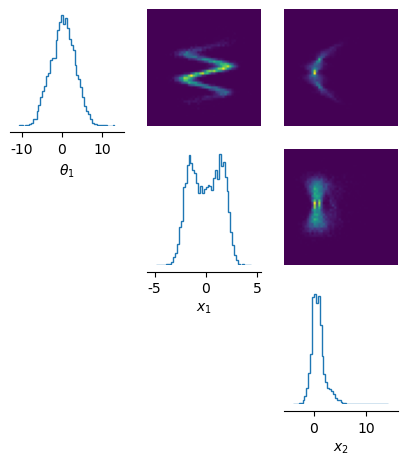

In [21]:
# with use_style("pyloric"):
fig,axes = pairplot(np.array(samples[:,-1,:]), figsize=(5,5), labels=["$\\theta_1$", "$x_1$", "$x_2$"], diag_kind="kde", color="black", linewidth=2)


In [22]:
# Marginal estimation alone (if you leave out marginal consitstency in the loss, this will fail but the above will still work!)
marginal_samples1  = sample_fn(jrandom.PRNGKey(0), (10000,), jnp.array([0,]), condition_mask=jnp.zeros((1,), dtype=int), condition_value=jnp.zeros((1,)))
marginal_samples2  = sample_fn(jrandom.PRNGKey(0), (10000,), jnp.array([1,]), condition_mask=jnp.zeros((1,), dtype=int), condition_value=jnp.zeros((1,)))
marginal_samples3 = sample_fn(jrandom.PRNGKey(0), (10000,), jnp.array([2,]), condition_mask=jnp.zeros((1,), dtype=int), condition_value=jnp.zeros((1,)))

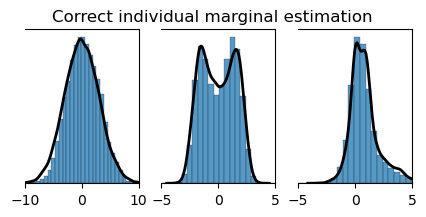

In [23]:
# with use_style("pyloric"):
fig, ax = plt.subplots(1,3, figsize=(5,2))
sns.histplot(marginal_samples1[:, -1, 0], bins=50, ax=ax[0], stat="density")
sns.histplot(marginal_samples2[:, -1, 0], bins=50, ax=ax[1], stat="density")
sns.histplot(marginal_samples3[:, -1, 0], bins=50, ax=ax[2], stat="density")
sns.kdeplot(data[:, 0, 0], ax=ax[0], color="black", linewidth=2)
sns.kdeplot(data[:, 1, 0], ax=ax[1], color="black", linewidth=2)
sns.kdeplot(data[:, 2, 0], ax=ax[2], color="black", linewidth=2)

ax[0].set_xlim(-10,10)
ax[1].set_xlim(-5,5)
ax[2].set_xlim(-5,5)
fig.suptitle("Correct individual marginal estimation")
for ax in ax:
    ax.yaxis.set_visible(False)
    # remove y spines
    ax.spines['left'].set_visible(False)
        

        


### 7) Arbitrary conditional distributions

In [29]:
def true_posterior(theta, x1=None, x2=None):
    potential_theta = partial(log_potential, x1=x1, x2=x2)
    potential_post = potential_theta(theta)
    potential_post = potential_post - potential_post.max()
    potential_post = jnp.exp(potential_post)
    potential_post = potential_post / jnp.trapezoid(potential_post, x=theta)
    return potential_post

In [30]:
# Full conditional estimation
theta = jnp.linspace(-10, 10, 1000)
x_o = data[4,:,0]
true_post = true_posterior(theta, x_o[1], x_o[2])
samples = sample_fn(jrandom.PRNGKey(0), (10000,), node_ids, condition_mask=jnp.array([0,1,1], dtype=jnp.bool_), condition_value=x_o)

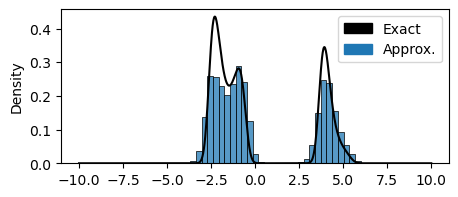

In [31]:
samples_theta = samples[...,-1, 0]
# with use_style("pyloric"):
fig = plt.figure(figsize=(5, 2))
sns.histplot(samples_theta, bins=50, stat="density")
plt.plot(theta, true_post, color="black", label="True posterior")
exact_patch = mpatches.Patch(color='black', label='Exact')
approx_patch = mpatches.Patch(color='C0', label='Approx.')
plt.legend(handles=[exact_patch, approx_patch])

In [32]:
# Partial conditional estimation
theta = jnp.linspace(-10, 10, 1000)
x_o = data[4,:,0]
true_post = true_posterior(theta, x_o[1], None)
samples = sample_fn(jrandom.PRNGKey(0), (10000,), node_ids, condition_mask=jnp.array([0,1,0], dtype=int), condition_value=x_o, time_steps=500)

(-10.0, 10.0)

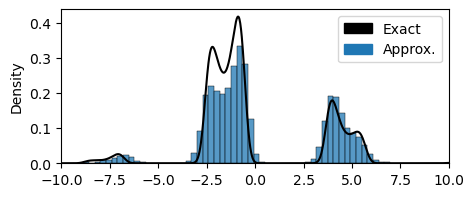

In [33]:

import matplotlib.patches as mpatches
samples_theta = samples[...,-1, 0]
# with use_style("pyloric"):
fig = plt.figure(figsize=(5, 2))
sns.histplot(samples_theta, bins=80, stat="density")
plt.plot(theta, true_post, color="black", label="True posterior")
exact_patch = mpatches.Patch(color='black', label='Exact')
approx_patch = mpatches.Patch(color='C0', label='Approx.')
plt.legend(handles=[exact_patch, approx_patch])
plt.xlim(-10, 10)


### 8) Arbitrary constraints

Here a simplified version constraint conditioning

In [34]:
# Simplified sampling with guidance...

def s(t):
    # Some scaling function
    t = jnp.atleast_1d(t)
    return jnp.exp(-t**2*5)*100

def log_step_fun(t,x,a,b):
    # Step_fn constraint -> Intervals
    scale = s(t)
    x1 = jax.nn.log_sigmoid(jnp.sum(scale * (x - a), axis=-1))
    x2 = jax.nn.log_sigmoid(jnp.sum(-scale * (x - b), axis=-1))

    return x1 + x2

def log_linear_fn_approximation(t,x, a):
    # Linear constrait <s,a> = 0.
    scale = s(t)
    a = a.reshape(-1,x.shape[1],1)
    x1 = jax.nn.log_sigmoid(scale *jnp.sum((x * a), axis=1))
    x2 = jax.nn.log_sigmoid(-scale *jnp.sum((x * a), axis=1))
    return x1 + x2

def log_polytope_fn_approximation(t,x, A):
    # Polytope constraint 
    scale = s(t)
    a = x.reshape(-1, x.shape[1])
    constraint = jax.nn.relu(scale * (jnp.matmul(a, A.T) - 1.)).max(axis=-1)
    constraint = jax.nn.log_sigmoid(-constraint) 
    return constraint



step_fn_score = jax.grad(lambda *args: log_step_fun(*args).sum(), argnums=1)
linear_fn_score = jax.grad(lambda *args: log_linear_fn_approximation(*args).sum(), argnums=1)
polytope_fn_score = jax.grad(lambda *args: log_polytope_fn_approximation(*args).sum(), argnums=1)
    

In [35]:
# Wappers around score functions to include the constraints

def interval_score(params, t, x, node_ids, condition_mask, edge_mask, a,b):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids), 1)
    score = model_fn(params,t, x, node_ids=node_ids, condition_mask=jnp.zeros_like(condition_mask), edge_mask=edge_mask)
    tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
    interval_score_est = step_fn_score(t,tweedies_x0_estimator,a,b).reshape(-1, len(node_ids), 1) * condition_mask.reshape(-1, len(node_ids), 1)
    return score + interval_score_est

def linear_score(params, t, x, node_ids, condition_mask, edge_mask, a):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids), 1)
    score = model_fn(params,t, x, node_ids=node_ids, condition_mask=jnp.zeros_like(condition_mask), edge_mask=edge_mask)
    tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
    linear_score_est = linear_fn_score(t,tweedies_x0_estimator,a) * condition_mask.reshape(-1, len(node_ids), 1)
    return score + linear_score_est

def polytope_score(params, t, x,  node_ids, condition_mask, edge_mask, A):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids), 1)
    score = model_fn(params,t, x, node_ids=node_ids, condition_mask=jnp.zeros_like(condition_mask), edge_mask=edge_mask)
    tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
    polytope_score_est = polytope_fn_score(t,tweedies_x0_estimator,A) #* condition_mask.reshape(-1, len(node_ids), 1)
    return score + polytope_score_est

score_fn1 = partial(interval_score, a=2.*jnp.ones(1), b=jnp.ones(1)*3)
score_fn3 = partial(linear_score, a=jnp.array([1., 5.]))
score_fn4 = partial(polytope_score, A=0.3*jax.random.normal(jrandom.PRNGKey(0), (8,2)))

In [36]:

samples1 = sample_fn(jrandom.PRNGKey(0), (1000,), time_steps=1000, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), score_fn=score_fn1, replace_conditioned=False)

In [37]:
samples1.shape

(1000, 1000, 2)

In [38]:

samples2 = sample_fn(jrandom.PRNGKey(0), (1000,), time_steps=1000, node_ids=jnp.array([0,1]), condition_mask=jnp.array([1,1], dtype=int), score_fn=score_fn3, replace_conditioned=False)

In [39]:
samples3 = sample_fn(jrandom.PRNGKey(0), (1000,), time_steps=1000, node_ids=jnp.array([0,1]), condition_mask=jnp.array([1,1], dtype=int), score_fn=score_fn4, replace_conditioned=False)

In [40]:
# Auxiliarly for plotting
# with jax.default_device(jax.devices("cpu")[0]):
def pot(x):
    return jnp.exp(log_polytope_fn_approximation(0.001, x, 0.3*jax.random.normal(jrandom.PRNGKey(0), (8,2))))


potential_fn = jax.vmap(jax.scipy.stats.gaussian_kde(data[:,[0,1], 0].T, bw_method="silverman"))
x = jnp.linspace(data[:, 0, 0].min(), data[:, 0, 0].max(), 200)
y = jnp.linspace(data[:, 1, 0].min(), data[:, 1, 0].max(), 200)
X, Y = jnp.meshgrid(x, y)
pos = jnp.dstack((X, Y))
Z_true = potential_fn(pos.reshape(-1,2)).reshape(200,200)
Z = pot(pos.reshape(-1,2)).reshape(200,200)


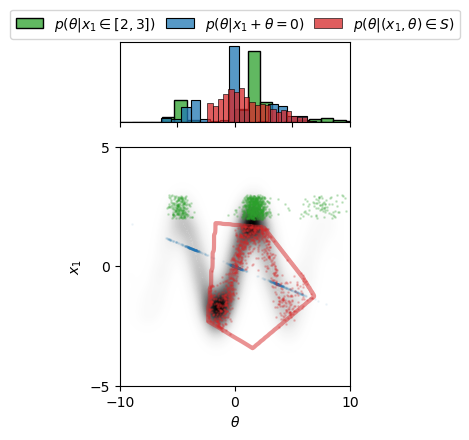

In [41]:
# from scoresbibm.plot import use_style
# with use_style("pyloric"):

fig, axs = plt.subplots(2, 1, figsize=(4., 4.5), gridspec_kw={'height_ratios': [1, 3]})

# 2D scatter plot
l = axs[1].contour(X, Y, Z,colors="tab:red", levels=[0.4], alpha=0.5, linewidths=3)
axs[1].contourf(X, Y, Z_true, cmap="Greys", levels=200, vmin=0, alpha=0.9)
axs[1].scatter(samples1[:, -1, 0], samples1[:, -1, 1], s=1, alpha=0.2, color="tab:green")
axs[1].scatter(samples2[:, -1, 0], samples2[:, -1, 1], s=1, alpha=0.05, color="tab:blue")
axs[1].scatter(samples3[:, -1, 0], samples3[:, -1, 1], s=1, alpha=0.2, color="tab:red")
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-5, 5)
axs[1].set_xlabel(r"$\theta$")
axs[1].set_ylabel(r"$x_1$")

# 1D marginal plot
_ = sns.histplot(samples1[:, -1, 0], ax=axs[0], bins=20, color="tab:green", stat="density")
_ = sns.histplot(samples2[:, -1, 0], ax=axs[0], bins=20,color="tab:blue", stat="density")
_ = sns.histplot(samples3[:, -1, 0], ax=axs[0],bins=20, color="tab:red", stat="density")
axs[0].set_xlim(-10, 10)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_ylabel("")
axs[0].yaxis.set_visible(False)
axs[1].set_xticks([-10,0,10])
axs[1].set_yticks([-5,0,5])

axs[0].legend([r"$p(\theta|x_1 \in [2,3])$", r"$p(\theta|x_1 + \theta = 0)$", r"$p(\theta|(x_1,\theta)\in S)$"], ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.5),columnspacing=0.7)
plt.tight_layout()
plt.show()

### 9) Change priors or likelihoods


$$ p(\theta) \propto \exp\left(-\frac{(\theta - \mu)^2}{2\sigma^2}\right) $$
$$ \nabla_\theta \log p(\theta) = \frac{\theta - \mu}{\sigma^2} $$

In training we have $\sigma^2 = 9$.
Now for any $\alpha$ we have
$$ p(\theta)^\alpha = \exp\left(-\frac{\alpha(\theta - \mu)^2}{2\sigma^2}\right) = \exp\left(-\frac{(\theta - \mu)^2}{2\sigma^2/\alpha}\right) $$

So if we want a certain variance $\sigma_0^2$. All we have to do is to multiply the score by $\alpha = \sigma^2/\sigma_0^2$.

If we want to change the mean then we have to add $\mu_0 - \mu / \sigma^2$ to the score.

In [88]:
# Score function wrappers with manipulations
def score_prior_change(params, t, x, node_ids, condition_mask, edge_mask, node_ids_to_change, scale=1., shift=0.):

    index = jnp.searchsorted(node_ids,node_ids_to_change)    
    score_unconditioned = model_fn(params, t, x[:,index], node_ids=node_ids_to_change, condition_mask=jnp.zeros_like(node_ids_to_change))

    score_conditional = model_fn(params, t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=edge_mask)
    score_conditional = score_conditional.at[:,index].set(scale * (score_unconditioned - shift) + (score_conditional[:,index] - score_unconditioned))
    
    return score_conditional

def score_likelihood_change(params, t, x, node_ids, condition_mask, edge_mask, node_ids_to_change, scale=1., shift=0.):

    index = jnp.searchsorted(node_ids,node_ids_to_change)    
    score_unconditioned = model_fn(params, t, x[:,index], node_ids=node_ids_to_change, condition_mask=jnp.zeros_like(node_ids_to_change))

    score_conditional = model_fn(params, t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=edge_mask)
    score_conditional =  score_conditional.at[:,index].set(score_unconditioned + (scale*(score_conditional[:,index] - score_unconditioned)) - shift)
    
    return score_conditional


In [89]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, mean_scale=jnp.sqrt(12.))
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_22157/2674575355.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


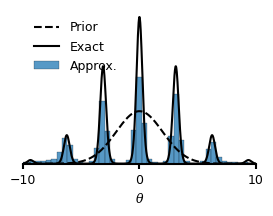

In [90]:
# Change to N(0, 2) prior -> shift = 9/4
score_fn_prior_change = partial(score_prior_change, scale=9/12., shift=0., node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (5000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_prior_change)
with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=100, stat="density", label= "Approx.")
    plt.plot(x, jax.scipy.stats.norm.pdf(x, 0, 2), color="black", linestyle="--", label="Prior")
    plt.plot(x, potential_post, color="black", label="Exact")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\theta$")
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    ax.set_xlim(-10,10)


In [91]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, mean_scale=1, mean_loc=2)
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_22157/586400139.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


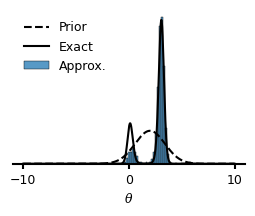

In [92]:
# Change to N(2, 1) prior -> shift = 9/2, loc = 2/9
score_fn_prior_change = partial(score_prior_change, scale=9/2, shift=-2/9, node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_prior_change)

with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=50, stat="density", label= "Approx.")
    plt.plot(x, jax.scipy.stats.norm.pdf(x, 2., np.sqrt(2.)), color="black", linestyle="--", label="Prior")
    plt.plot(x, potential_post, color="black", label="Exact")
    plt.legend()
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    plt.xlabel(r"$\theta$")

In [93]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, sigma_x1=jnp.sqrt(0.05))
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_22157/3693902762.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


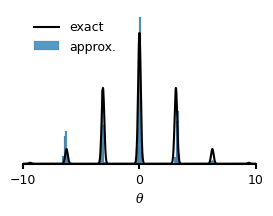

In [94]:
# Likelihood very certain
score_fn_likelihood_change = partial(score_likelihood_change, scale=0.5**2/0.05, shift=0., node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_likelihood_change)

with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=200, stat="density")
    plt.plot(x, potential_post, color="black")
    plt.legend(["exact", "approx."], loc="upper left")
    plt.xlim(-10,10)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    plt.xlabel(r"$\theta$")

In [95]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, sigma_x1=2.)
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_22157/4120217402.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


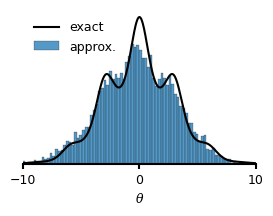

In [96]:
# Likelihood very certain
score_fn_likelihood_change = partial(score_likelihood_change, scale=0.5**2/4., shift=0., node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (10000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_likelihood_change)

with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=100, stat="density")
    plt.plot(x, potential_post, color="black")
    plt.legend(["exact", "approx."], loc="upper left")
    plt.xlim(-10,10)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    plt.xlabel(r"$\theta$")